## Import data 

In [1]:
#import all data
#train data from kaggle
import pandas as pd

train_transaction = pd.read_csv('data.csv')
train_identity = pd.read_csv('train_identity.csv')

# Merge two tables
data = pd.merge(data, train_identity, on = 'TransactionID', how = 'inner')


## Preprocessing

In [33]:
import gc
del train_transaction
del train_identity
gc.collect()



In [35]:
# Analyzing V(1-339) in this section
# Calculate correlation for Vesta Engineered features and sort by highest
vesta_features = []
for i in range(1, 340):
  access = f"V{i}"
  try:
    corr = data[access].corr(data['isFraud'])
    vesta_features.append((corr, access))
  except:
    print('failed')
vesta_features.sort(reverse=True)
top_100_vesta = {}
for i in range(0, 25):
  top_100_vesta[vesta_features[i][1]] = 0


# Analyzing D(1-15) now through same correlation method
# Data features
data_features = []
for i in range(1, 15):
  access = f"D{i}"
  corr = data[access].corr(data['isFraud'])
  data_features.append((corr, access))

top_data_features = {}
data_features.sort(reverse=True)
for i in range(0, 5):
  top_data_features[data_features[i][1]] = 0

c:\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [36]:
# Remove low correlation vesta features 
for i in range(1, 340):
  access = f"V{i}"
  if access not in top_100_vesta:
    data.drop(access, axis=1, inplace=True)

# Drop low correlation data features  
for i in range(1, 15):
  access = f"D{i}"
  if access not in top_data_features:
    data.drop(access, axis=1, inplace=True)

In [37]:
# Switch categorical column to category with highest proportion of fraud
data['product_type_c'] = data['ProductCD'].apply(lambda x: 1 if x == 'C' else 0)
data.drop('ProductCD', axis=1, inplace=True)

In [38]:
# Remove empty cells in this cell 
empty_cells = data.isnull().sum()

# proportion of empty cells in each column
prop_empty = empty_cells/len(data)

# empty column is where more than 20% of cells are empty2
empty_cols = empty_cells[prop_empty > 0.2].index
data.drop(columns = empty_cols, inplace = True)

Index(['addr1', 'addr2', 'dist1', 'dist2', 'D9', 'D11', 'D12', 'D14', 'D15',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V23',
       'V24', 'V45', 'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10',
       'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
       'id_27', 'id_30', 'id_32', 'id_33', 'id_34'],
      dtype='object')


In [39]:

# Drop transactionID, we're not "turning in" so unneeded
data.drop(columns=['TransactionID'], inplace=True)

(144233, 58)


In [41]:
# need to replace missing cells with median for numerical data
num_cols = data.select_dtypes(include=['number']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

In [43]:
# Replace empty categorical cells with 'Unknown' value
bad_cols = data.isnull().index
data.fillna('Unknown', inplace=True)


In [45]:
# separate features and labels
features = data.drop('isFraud', axis=1)
labels = data['isFraud']

In [47]:
# Standardize
from sklearn.preprocessing import StandardScaler

numeric_cols = features.select_dtypes(include=['number']).columns
numeric_data = features[numeric_cols]

# Declare and use scaler on numeric columns
scalar = StandardScaler()
data_scaled = scalar.fit_transform(numeric_data)
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols)
data_scaled = pd.concat([data_scaled_df, data.drop(columns=numeric_cols)], axis=1)


In [48]:
# Perform one-hot encoding in this cell 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Select category columns
cat_cols = data_scaled.select_dtypes(include=['object', 'category']).columns

# Declare preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(sparse_output=False), cat_cols)
    ])

data_transformed = preprocessor.fit_transform(data_scaled)

cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Combine all feature names
all_feature_names = list(num_cols) + list(cat_feature_names)
# Create DataFrame
data_final = pd.DataFrame(data_transformed, columns=all_feature_names)


In [49]:
# Free up memory here that was needed for colab 
#del train_transaction
#del train_identity
del data
del empty_cells
del prop_empty
del empty_cols
del num_cols
del bad_cols
del scalar
#del numeric_data
#del data_scaled
#del data_scaled_df
del cat_cols
del preprocessor
del data_transformed
del cat_feature_names
del all_feature_names
import gc
gc.collect()

In [50]:
# Oversample fraud class in this cell to help train neural network and other models better
from imblearn.over_sampling import SMOTE
data_final = data_final.sample(frac=0.5, random_state=42)
features = data_final.drop('isFraud', axis=1)
labels = data_final['isFraud']

# Oversample with SMOTE
smote = SMOTE(random_state=42)
oversampled_features, oversampled_labels = smote.fit_resample(features, labels)

In [52]:
# Feature selection using LASSO to make models easier to run
from sklearn.linear_model import LassoCV
lasso = LassoCV(max_iter = 10000, alphas=[0.1, 0.01, 0.001])
lasso.fit(oversampled_features, oversampled_labels)
selected_features = lasso.coef_ != 0
X_lasso = oversampled_features.loc[:, selected_features]

In [53]:
# Apply selected features (nonzero) to the model 
X_lasso = oversampled_features.loc[:, selected_features]
true_labels = data_final['isFraud']
data_final = data_final.drop(columns=['isFraud'])
data_final = data_final.loc[:, selected_features]

## Logistic Regression

Accuracy: 0.8953133666112035
Precision: 0.4128768523249872
Recall: 0.6911890504704876
F1 Score: 0.5169545745361483


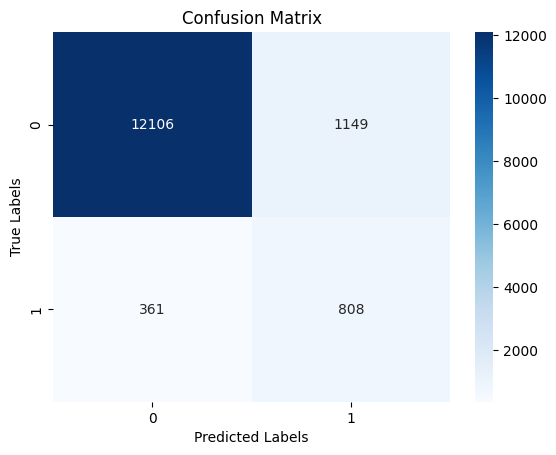

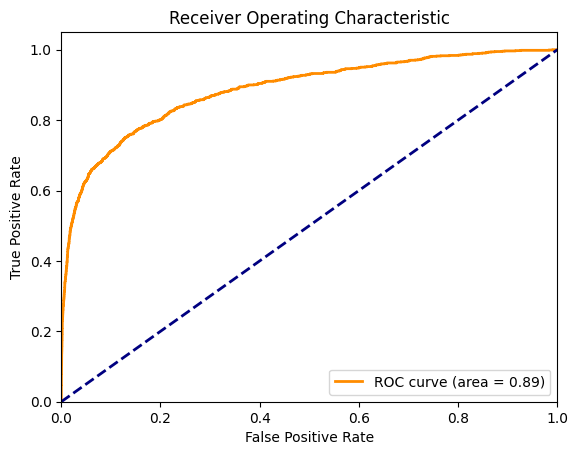

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Train on oversampled data here 
X_train, _, y_train, _ = train_test_split(X_lasso, oversampled_labels, test_size=0.2, shuffle=False)

# Create logistic regression model 
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)


# Making predictions on the test set which is not oversampled
_, X_test, _, y_test = train_test_split(data_final, true_labels, test_size=0.2, shuffle=False)
y_pred = model.predict(X_test)

# Accuracy measures 
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)

# Print scores 
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")


# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Neural Network Section

In [57]:
from sklearn.model_selection import train_test_split
#nn_train_data = oversampled_data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

features = X_lasso
target = oversampled_labels

features_tensor = torch.from_numpy(np.array(features)).float()
target_tensor = torch.from_numpy(np.array(target)).float().view(-1, 1)  # Adjust the view if needed

X_train, X_eval, y_train, y_eval = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)


# Create custom class so data can be used for training
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Declare dataset to be loaded
dataset = CustomDataset(X_train, y_train)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Declare model with 4 hidden layers
model = nn.Sequential(
    nn.Linear(features.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()  # Add a sigmoid activation for binary classification
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00002)

# Training epochs 
num_epochs = 25
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/25], Loss: 0.35425078868865967
Epoch [2/25], Loss: 0.17171181738376617
Epoch [3/25], Loss: 0.08239629119634628
Epoch [4/25], Loss: 0.05586317181587219
Epoch [5/25], Loss: 0.12599752843379974
Epoch [6/25], Loss: 0.06442195922136307
Epoch [7/25], Loss: 0.10064335912466049
Epoch [8/25], Loss: 0.10168930143117905
Epoch [9/25], Loss: 0.028562040999531746
Epoch [10/25], Loss: 0.09129020571708679
Epoch [11/25], Loss: 0.026708906516432762
Epoch [12/25], Loss: 0.16921360790729523
Epoch [13/25], Loss: 0.13391537964344025
Epoch [14/25], Loss: 0.1711580604314804
Epoch [15/25], Loss: 0.04468381404876709
Epoch [16/25], Loss: 0.02095171995460987
Epoch [17/25], Loss: 0.035029295831918716
Epoch [18/25], Loss: 0.024348700419068336
Epoch [19/25], Loss: 0.016433779150247574
Epoch [20/25], Loss: 0.01207446213811636
Epoch [21/25], Loss: 0.027851900085806847
Epoch [22/25], Loss: 0.046875614672899246
Epoch [23/25], Loss: 0.0023713374976068735
Epoch [24/25], Loss: 0.1437726616859436
Epoch [25/25], Los

Accuracy: 0.9837077093732668
Precision: 0.8642745709828393
Recall: 0.9478186484174508
F1 Score: 0.9041207670338638


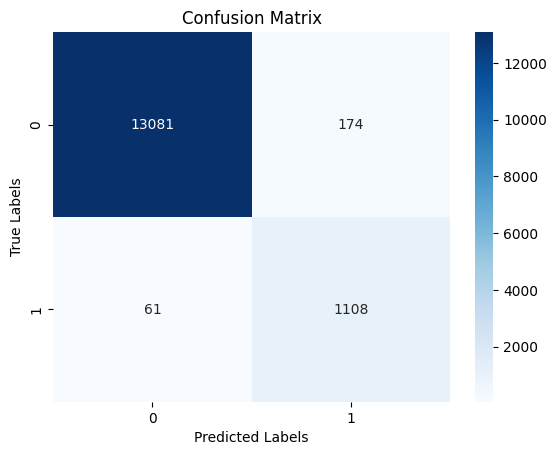

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix,  precision_score,  recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

features = data_final 
target = true_labels

# Create training data from non-oversampled data 
features_tensor = torch.from_numpy(np.array(features)).float()
target_tensor = torch.from_numpy(np.array(target)).float()
_, X_eval, _, y_eval = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)


model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_eval)
    predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions

# Evaluation metrics
accuracy = accuracy_score(y_eval.numpy(), predictions.numpy())
precision = precision_score(y_eval.numpy(), predictions.numpy())
recall = recall_score(y_eval.numpy(), predictions.numpy())
f1 = f1_score(y_eval.numpy(), predictions.numpy())
confusion = confusion_matrix(y_eval.numpy(), predictions.numpy())

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


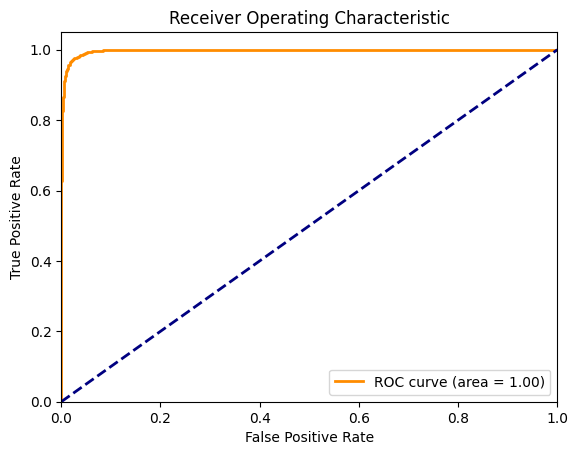

In [59]:
from sklearn.metrics import roc_curve, auc

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    eval_outputs = model(X_eval)
    fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_eval.numpy(), eval_outputs.numpy())
    roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators' : [10, 50, 100, 200],
    'max_depth' : [2, 5, 10 , 15, 20],
    'max_features' : [2, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'bootstrap' : [True, False]
}

# Cross validation with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                               n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)

X_train, X_eval, y_train, y_eval = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 20, 'bootstrap': False}


Accuracy: 0.9645729339988908
Precision: 0.9422043010752689
Recall: 0.5996578272027374
F1 Score: 0.7328802927339257

Confusion Matrix:


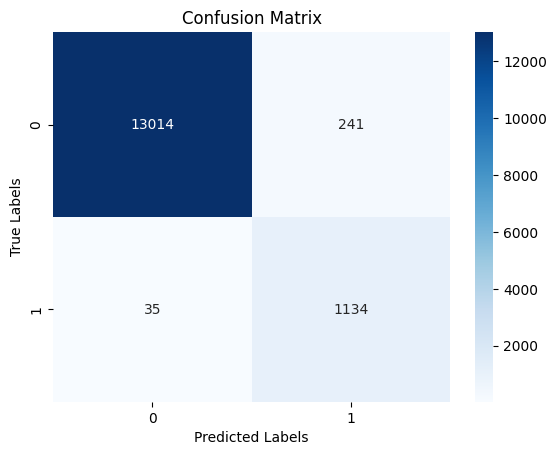

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
_, X_, _, y_eval = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)

# Createa predictions
y_pred_rf = best_rf.predict(X_test)

# Calculate accuracy metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print metrics 
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")


# Create confusion matrix
print("\nConfusion Matrix:")
confusion_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix 
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

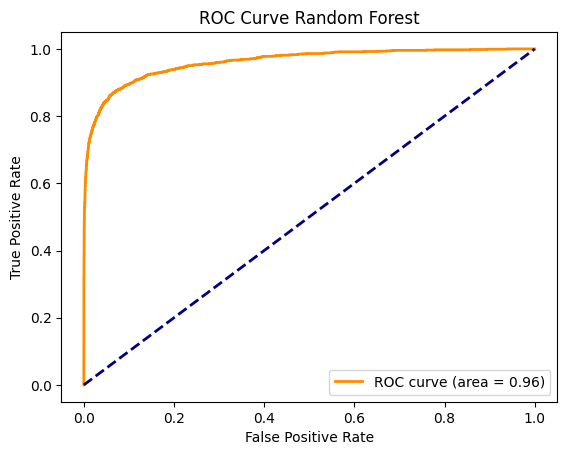

In [ ]:
# create ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities 
y_probs = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs)

roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve 
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.legend(loc="lower right")
plt.show()

## SVM

In [60]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV

# SVM possilbe alpha values 
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1]
}

# Create training data
X_train, X_eval, y_train, y_eval = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)


# SVM provided by sklearn 
clf = SGDClassifier()
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv=5, verbose=2, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
best_clf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

c:\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................................alpha=0.0001; total time=   1.5s
[CV] END .......................................alpha=0.0001; total time=   0.6s
[CV] END .......................................alpha=0.0001; total time=   0.9s
[CV] END .......................................alpha=0.0001; total time=   0.7s
[CV] END .......................................alpha=0.0001; total time=   0.7s
[CV] END ........................................alpha=0.001; total time=   0.3s
[CV] END ........................................alpha=0.001; total time=   0.3s
[CV] END ........................................alpha=0.001; total time=   0.4s
[CV] END ........................................alpha=0.001; total time=   0.3s
[CV] END ........................................alpha=0.001; total time=   0.3s
[CV] END .........................................alpha=0.01; total time=   0.2s
[CV] END ........................................

Accuracy: 0.9371186910704381
Precision: 0.8659217877094972
Recall: 0.26518391787852863
F1 Score: 0.4060248853962017
Confusion Matrix: 
[[13207    48]
 [  859   310]]


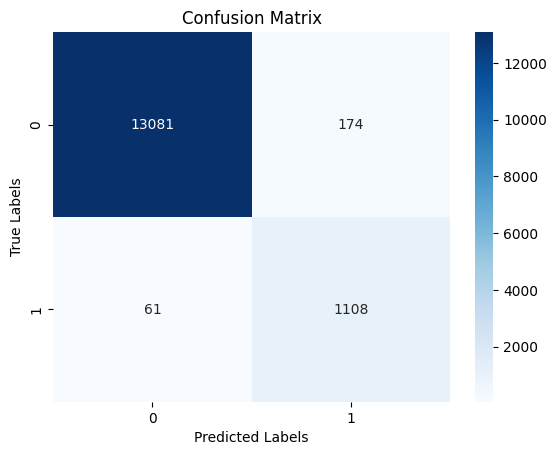

In [61]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
_, X_test, _, y_test = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)

y_pred = best_clf.predict(X_test)

# Get accuracy metrics and confsion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{cf_matrix}")

# Plot matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




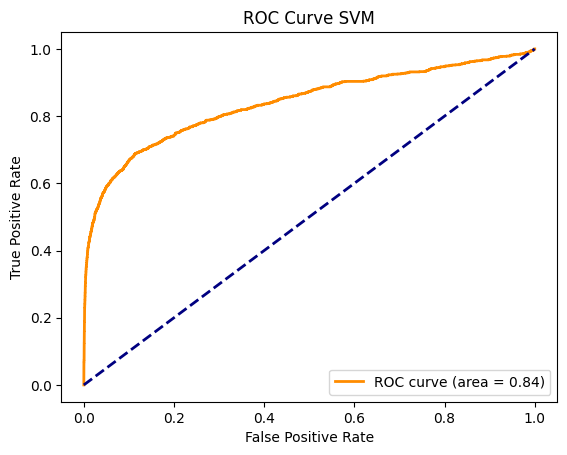

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test data
y_probs = best_clf.decision_function(X_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_probs)

roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")
plt.show()

# KNN

Accuracy: 0.9475180255130339
Precision: 0.8759124087591241
Recall: 0.41060735671514115
F1 Score: 0.559114735002912

Confusion Matrix:


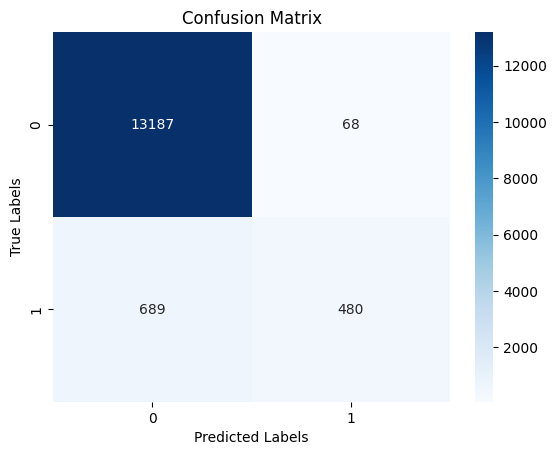

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 

# Fit to training data 
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Get accuracy measures 
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
confusion_knn = confusion_matrix(y_test, y_pred_knn)

# Print values
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")
print("\nConfusion Matrix:")


# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Best K: 3
Highest Accuracy: 0.95%


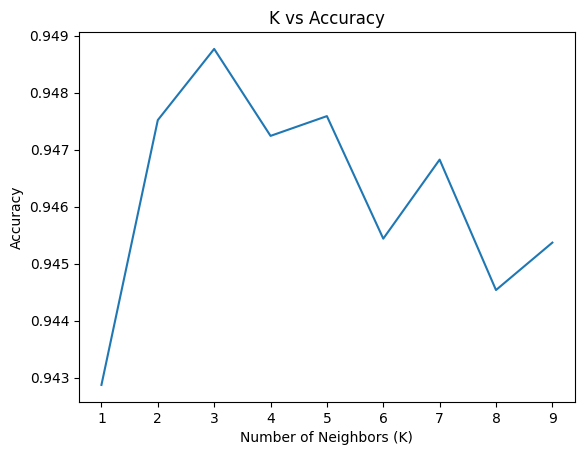

In [67]:
# Compare K values 
highest_accuracy = 0
best_k = 0

accuracies = []
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_k = k

print(f"Best K: {best_k}")
print(f"Highest Accuracy: {highest_accuracy:.2f}%")

plt.plot(range(1, 10), accuracies)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy')
plt.show()

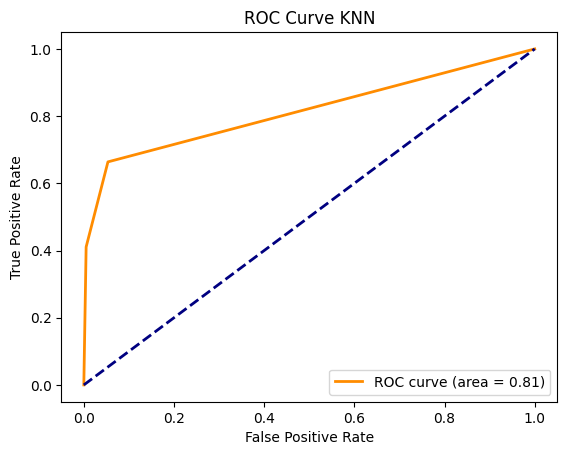

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test data
y_probs = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_probs)

roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc="lower right")
plt.show()
